In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Voice_Vertification

/content/drive/MyDrive/Voice_Vertification


In [3]:
!pip install pydub

In [4]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import os
import random 
import glob

# 1. Utils 

- In this section, I wanna look into the data to have more understand about it. I'll do some examine:
  - Folder `Dataset` contains 400 subjects corresponding to `400` people. Each will have about `5-20` speech. 
  - Loading certain wave files and `visualize` them both in time domain and frequency domain (`mfccs` in details)
  - Also, `splitting` the wav files into multiple wave files(set the `time_sample = 1.5s`) 
  - Next, `adding some noise` to the data is taken into account
  - `Zero-Padding` at both directions is also necessary

In [5]:
DATA_ROOT = 'Zalo_Voice_Verification/Train-Test-Data/dataset'
subject_foders = os.listdir(DATA_ROOT)
print(len(subject_foders))
test_subject_folder =  os.path.join(DATA_ROOT, random.choice(subject_foders)) 

400


In [6]:
test_audio_file1 = os.path.join(test_subject_folder,random.choice(os.listdir(test_subject_folder)))
ipd.Audio(test_audio_file1)

In [7]:
test_audio_file = os.path.join(test_subject_folder,random.choice(os.listdir(test_subject_folder)))
ipd.Audio(test_audio_file)

In [8]:
print(test_audio_file)

Zalo_Voice_Verification/Train-Test-Data/dataset/806-M-32/806-23.wav


In [9]:
signal, sr = librosa.load(test_audio_file1,sr=16000)

In [10]:
print(len(signal)/sr)

1.68875


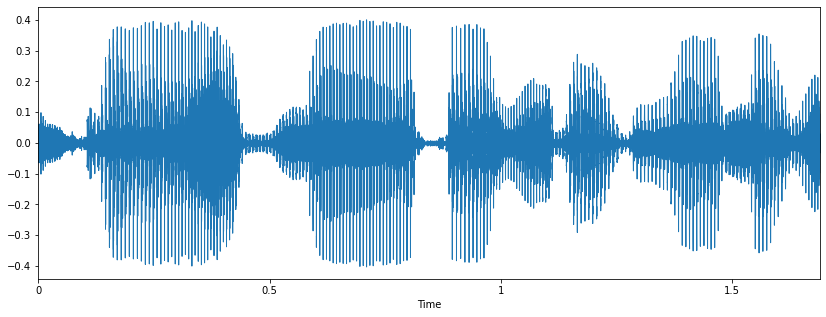

In [11]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(signal, sr)

In [12]:
from pydub import AudioSegment
import os

save_folder='splitaudio'

def split(i,test_audio_file,save_folder='splitaudio'):
  subject_folder = '/'.join(test_audio_file.split('/')[:-1])
  save_folder = os.path.join(subject_folder,save_folder)
  try:
    os.rmdir(save_folder)
  except:
    if not os.path.isdir(save_folder):
        os.mkdir(save_folder)
  audio = AudioSegment.from_file(test_audio_file)
  lengthaudio = len(audio)
  start = 0
  threshold = 1500 # 1.5s
  end = 0
  counter = 0

  while start < len(audio):
      end += threshold
      chunk = audio[start:end]
      filename = f'{i}_chunk{counter}.wav' 
      filename = os.path.join(save_folder,filename)
      try:
        chunk.export(filename, format="wav")
      except:
        pass
      counter +=1
      start += threshold

In [13]:
'''
for subject_foder in tqdm(subject_foders):
  print(subject_foder)
  subject_foder = os.path.join(DATA_ROOT, subject_foder)
  wav_paths = glob.glob(os.path.join(subject_foder,'*.wav'))
  for i,wav_path in enumerate(wav_paths):
    split(i,wav_path,save_folder='splitaudio')
'''

"\nfor subject_foder in tqdm(subject_foders):\n  print(subject_foder)\n  subject_foder = os.path.join(DATA_ROOT, subject_foder)\n  wav_paths = glob.glob(os.path.join(subject_foder,'*.wav'))\n  for i,wav_path in enumerate(wav_paths):\n    split(i,wav_path,save_folder='splitaudio')\n"

In [14]:
test_subject_folder = os.path.join(test_subject_folder,save_folder)
test_audio_file = os.path.join(test_subject_folder,random.choice(os.listdir(test_subject_folder)))
ipd.Audio(test_audio_file)

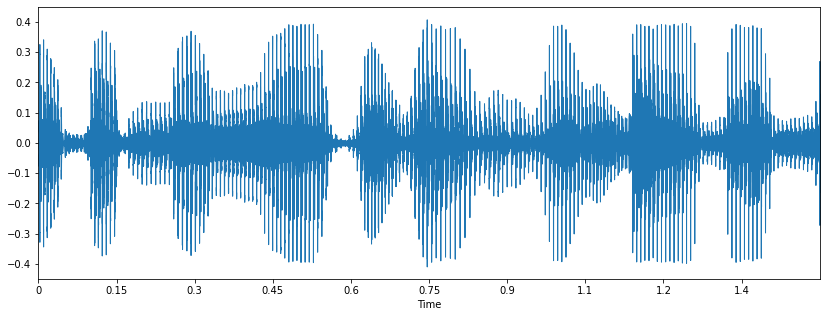

In [15]:
signal, sr = librosa.load(test_audio_file,sr=17000)
plt.figure(figsize=(14, 5))
librosa.display.waveplot(signal, sr)

In [16]:
mfccs = librosa.feature.mfcc(signal, n_mfcc=13, sr=sr,n_fft=2048)
print(len(signal)/sr)
print(len(signal))

1.5
25500


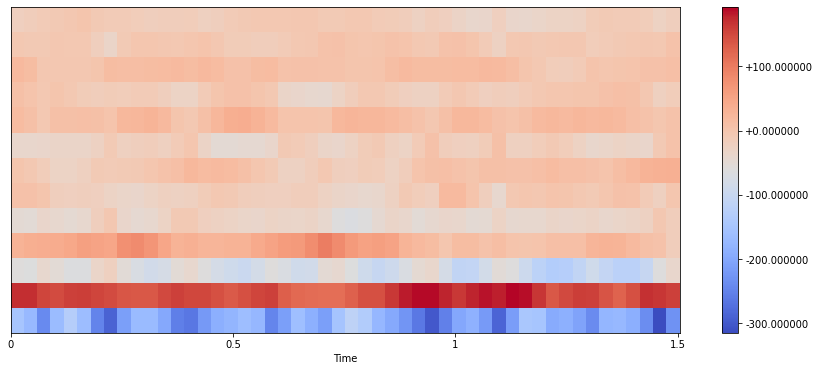

In [17]:
plt.figure(figsize=(15,6))
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar(format="%+2f")
plt.show()

In [18]:
mfccs = mfccs/np.linalg.norm(mfccs)
noise = np.random.normal(0, .1, mfccs.shape)
new_mfccs = mfccs + noise

In [19]:
new_mfccs.shape

(13, 50)

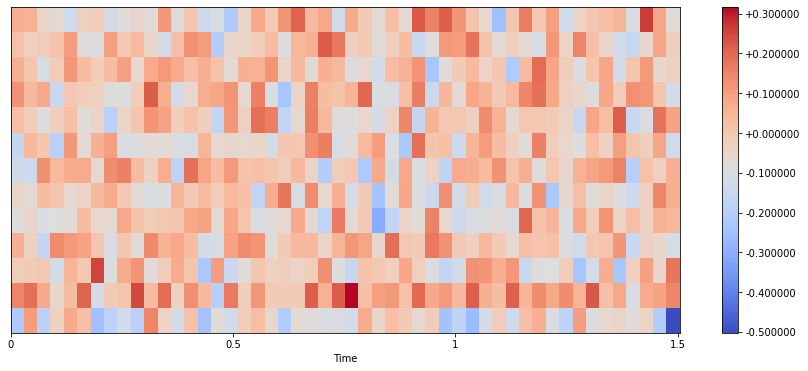

In [20]:
plt.figure(figsize=(15,6))
librosa.display.specshow(new_mfccs, x_axis='time', sr=sr)
plt.colorbar(format="%+2f")
plt.show()

In [21]:
MAX_LEN = 47
seq = new_mfccs.shape[1]
if seq<MAX_LEN:
  pad = np.zeros((new_mfccs.shape[0],MAX_LEN-seq))
  new_mfccs = np.concatenate([new_mfccs,pad],axis = 1)

In [22]:
new_mfccs.shape

(13, 50)

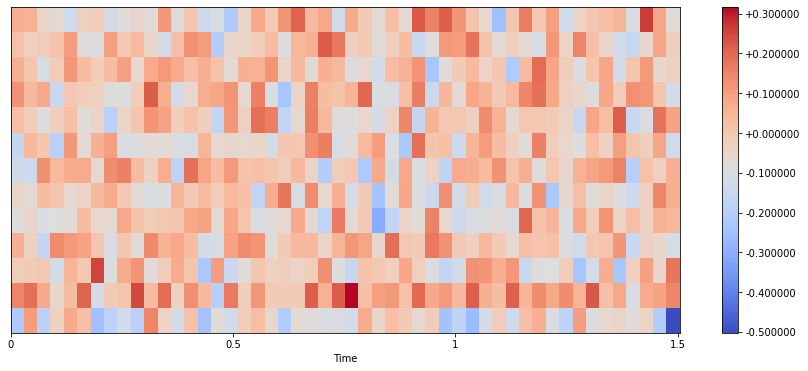

In [23]:
plt.figure(figsize=(15,6))
librosa.display.specshow(new_mfccs, x_axis='time', sr=sr)
plt.colorbar(format="%+2f")
plt.show()

In [24]:
paths = glob.glob(DATA_ROOT+'/*/splitaudio/*.wav')

In [25]:
print(len(paths))

19440


In [26]:
def get_prefix(file):
  split = file.split('/')
  return '/'.join(split[:-1]),split[-3]

In [27]:
print(get_prefix(paths[0]))

('Zalo_Voice_Verification/Train-Test-Data/dataset/522-F-25/splitaudio', '522-F-25')


# 2. Dataset

In [28]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torch.utils.data import Dataset


class VoiceData(Dataset):

  def __init__(self,wave_paths = paths, sr = 16000,n_mfcc=13):
    super(VoiceData, self).__init__()
    self.wave_paths = wave_paths
    self.sr = sr
    self.MAX_LEN = MAX_LEN
    self.n_mfcc = n_mfcc
    self.subjects = np.array(subject_foders)

  def __len__(self):
    return len(self.wave_paths)

  def extract(self,file):
    signal, sr = librosa.load(file,sr=self.sr)
    nfft = len(signal) - 1 
    mfccs = librosa.feature.mfcc(signal, n_mfcc=self.n_mfcc, sr=sr , n_fft= nfft)
    mfccs = mfccs/np.linalg.norm(mfccs)
    noise = np.random.normal(0, .01, mfccs.shape)
    new_mfccs = mfccs + noise
    seq = new_mfccs.shape[1]
    if seq<self.MAX_LEN:
      pad = np.zeros((new_mfccs.shape[0],self.MAX_LEN-seq))
      new_mfccs = np.concatenate([new_mfccs,pad],axis = 1)
    return new_mfccs

  def __getitem__(self,idx):
    file1 = self.wave_paths[idx]
    predix, subject1= get_prefix(file1)
    label = idx%2
    if label == 1:
      wav_files = np.array(glob.glob(predix+'/*.wav'))
      other_wav_files = wav_files[wav_files!=file1]
      file2 = random.choice(other_wav_files)
    else:
      other_folders = self.subjects[self.subjects!=subject1]
      predix_2 = predix.replace(subject1,random.choice(other_folders))
      file2 = random.choice(glob.glob(predix_2+'/*.wav'))
    file1_mfccs = self.extract(file1)
    file1_mfccs = torch.FloatTensor(file1_mfccs)
    file2_mfccs = self.extract(file2)
    file2_mfccs = torch.FloatTensor(file2_mfccs)
    return torch.unsqueeze(file1_mfccs,dim=0),torch.unsqueeze(file2_mfccs,dim=0),torch.FloatTensor([label])


In [29]:
dataset = VoiceData()

In [30]:
train_loader = DataLoader(
        dataset=dataset,
        batch_size=128,
        num_workers=2
)

# 3. Model

In [31]:
import torch.nn as nn  
import torch.nn.functional as F


class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=.2),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=.2),

            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Dropout2d(p=.2),
        )
        self.fc1 = nn.Linear(31680, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)


    def forward(self, input1, input2):
        output1 = self.cnn1(input1)
        output1 = output1.view(output1.size()[0], -1)#make it suitable for fc layer.
        output2 = self.cnn1(input2)
        output2 = output2.view(output2.size()[0], -1)
        
        output = torch.cat((output1, output2),1)
        output = F.relu(self.fc1(output))
        output = F.relu(self.fc2(output))
        output = self.fc3(output)
        return output

In [ ]:
in1 = torch.randn((1,1,13,47))
in2 = torch.randn((1,1,13,47))
model = SiameseNetwork()
print(model(in1,in2))

# 4. Train

In [ ]:
device = 'cuda'
model = model.to(device)
criterion = nn.BCEWithLogitsLoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
epoch_n = 5
for epoch in range(epoch_n):
  loss_epoch = 0
  for em1,em2,label in tqdm(train_loader):
    em1 = em1.to(device)
    em2 = em2.to(device)
    label = label.to(device)
    optimizer.zero_grad()
    out = model(em1,em2)
    loss = criterion(out,label)
    print(loss.item())
    loss_epoch+=loss.item()
    loss.backward()
    optimizer.step()